In [207]:
!date

Mon Oct 28 03:40:37 PDT 2024


In [208]:
%env CONDA_PREFIX

'/c4/home/derek/miniconda3/envs/deepripe'

# Model Attribution plots with DeepLift/DeepShap

In [209]:
import numpy as np
np.random.seed(1)

import os
import random
import sys
import glob
import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [271]:
import pandas as pd
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt
from deeplift.visualization import viz_sequence
import logomaker



from pathlib import Path
import json
import shutil


import pysam 
from scipy.stats import pearsonr, spearmanr


#import modified basenji modules 
sys.path.append("/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing")
from basenji_.basenji.dna_io import dna_1hot

import tensorflow as tf
from keras import regularizers

In [272]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [273]:
##set memory usage 

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [274]:
pwd

'/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN'

## generate and train ExplaiNN model 

In [275]:
model_path = '/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/DeepRiPe/'

In [276]:
sys.path.append(model_path+'Scripts/')

from util_funcs import precision, recall

custom_objects={'precision':precision,
                'recall':recall,
                  }

In [277]:
seq_len = 800
region_len = 1000
input_sequence_split = 4
n_tasks = 1

In [278]:
input_seq = tf.keras.Input(shape=(seq_len, 4), name='input_seq')
input_region = tf.keras.Input(shape=(region_len, 4), name='input_region')
                           
input_seq_1, input_seq_2, input_seq_3, input_seq_4 = tf.split(input_seq, input_sequence_split, axis=1)
input_region_1, input_region_2, input_region_3, input_region_4 = tf.split(input_region, input_sequence_split, axis=1)
                              
inputs_seq = {}
inputs_region = {}

inputs_seq[0] = tf.keras.layers.Masking(mask_value=0)(input_seq_1)
inputs_seq[1] = tf.keras.layers.Masking(mask_value=0)(input_seq_2)
inputs_seq[2] = tf.keras.layers.Masking(mask_value=0)(input_seq_3)
inputs_seq[3] = tf.keras.layers.Masking(mask_value=0)(input_seq_4)

inputs_region[0] = tf.keras.layers.Masking(mask_value=0)(input_region_1)
inputs_region[1] = tf.keras.layers.Masking(mask_value=0)(input_region_2)
inputs_region[2] = tf.keras.layers.Masking(mask_value=0)(input_region_3)
inputs_region[3] = tf.keras.layers.Masking(mask_value=0)(input_region_4)

In [279]:
orig_models = {}
input_layers = {}
output_layers = {}
base_models = {}
currents = {}
# 

# for i, model in enumerate(glob.glob(model_path + 'Results/PARCLIP_models/hek293/*.h5')):

for i, model in enumerate(([i for i in glob.glob(model_path + 'Results/Encode_models/K562/*.h5') if 'seq' in i] + 
                            [i for i in glob.glob(model_path + 'Results/Encode_models/HepG2/*.h5') if 'seq' in i]
                            )
):
    
    orig_models[i] = tf.keras.models.load_model(model, custom_objects = custom_objects, compile=False)
    
    for j in range(input_sequence_split):
        
        input_layers[i,j] = orig_models[i].inputs[0]
        # input_layers[i,j] = orig_models[i].inputs
        
        output_layers[i,j] = orig_models[i].get_layer('output').output
        
        base_models[i,j] = tf.keras.Model(inputs=input_layers[i,j], outputs=output_layers[i,j])
        
        base_models[i,j].trainable = False
        
        currents[i,j] = base_models[i,j](inputs_seq[j], training=False)
        # currents[i,j] = base_models[i,j]([inputs_seq[j], inputs_region[j]], training=False)
        
        
        

In [280]:
current = tf.concat(currents.values(), axis=1)

output = tf.keras.layers.Dense(n_tasks, #kernel_initializer='HeUniform',
                               # kernel_constraint= tf.keras.constraints.MaxNorm(max_value=0.05, axis=0),
                              )(current)

model = tf.keras.Model(input_seq, output, name='deepripe_explainn')
# model = tf.keras.Model((input_seq, input_region), output, name='deepripe_explainn')


## get data 

In [281]:
#import modified basenji modules 
sys.path.append("/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/basenji_/")

from basenji_.basenji import dataset

from basenji_.basenji.metrics import PearsonR

In [282]:
out_dir = '/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN/data_out/EN_RG_multitask_DeltaPSI_sig_0.1_train_valid_deepripe/'

data_dir = [glob.glob(out_dir+'/fold*/')[3]] 
params_file = data_dir[0]+'params.json'

In [283]:
data_dir

['/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN/data_out/EN_RG_multitask_DeltaPSI_sig_0.1_train_valid_deepripe/fold3/']

In [284]:
with open(params_file) as params_open:
          params = json.load(params_open)
params_model = params['model']
params_train = params['train']
os.makedirs(out_dir, exist_ok=True)
if params_file != '%s/params.json' % out_dir:
    shutil.copy(params_file, '%s/params.json' % out_dir)

In [285]:
#read datasets
train_data = []
eval_data = []
test_data = []


seq_track=True


for data_dir in data_dir:
    # load train data
    train_data.append(dataset.ExonDataset(data_dir,
        split_label='train',
        batch_size=params_train['batch_size'],
        shuffle_buffer=params_train.get('shuffle_buffer', params_model['seq_length']),
        mode='train',
        splice_track=False,
             # annotation_tracks=True
                                         ))

    # load eval data
    eval_data.append(dataset.ExonDataset(data_dir,
      split_label='valid',
      batch_size=params_train['batch_size'],
      mode='eval',
      splice_track=False,
            # annotation_tracks=True
                                        ))
    
    # # load test data
    # test_data.append(dataset.ExonDataset(data_dir, 
    #     split_label='test',
    #   batch_size=params_train['batch_size'],
    #   mode='eval',
    #   splice_track=False
    #                                      ))
            
        
if seq_track == 0:
    params_model['seq_depth'] -= 4
# if splice_track == 0:

## train model

In [286]:
num_targets = model.output_shape[-1]

model_metrics = [PearsonR(num_targets)
                ]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                    beta_1=0.9, beta_2=0.999)

In [287]:
# define callbacks
save_best=tf.keras.callbacks.ModelCheckpoint('%s/model_best.h5'%out_dir,
                                            save_best_only=True, 
                                             monitor='val_pearsonr',
                                             mode='max', 
                                             verbose=1)


lradjust = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, cooldown=1)

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_pearsonr', min_delta=1e-4, patience=15, mode='max',restore_best_weights=True, verbose=1
                                             )

In [288]:
model.compile(optimizer=optimizer, 
                  loss='mse',
                  metrics=model_metrics
                 )

In [289]:
train_data[0].numpy()[1].squeeze(axis=1)

array([[-0.12595961,  0.12595924],
       [ 0.27208598, -0.27208584],
       [-0.15505696,  0.15505741],
       ...,
       [ 0.10242543, -0.10242539],
       [-0.14761091,  0.14761029],
       [ 0.52372065, -0.52372066]])

In [290]:
# %%time


# history = model.fit(x=(train_data[0].numpy()[0][0][:,0,:,:],train_data[0].numpy()[0][1][:,0,:,:]),
#                     y=train_data[0].numpy()[1].squeeze(axis=1)[:,0],
#                       epochs=1000,
#                     validation_data=((eval_data[0].numpy()[0][0][:,0,:,:],eval_data[0].numpy()[0][1][:,0,:,:]),
#                             eval_data[0].numpy()[1].squeeze(axis=1)[:,0]),
#                         callbacks=[
#                          #  save_best, 
#                            early_stop,
#                             lradjust, 
#                                  ]
#              )

In [291]:
%%time


history = model.fit(x=train_data[0].numpy()[0][:,0,:,:],
                    y=train_data[0].numpy()[1].squeeze(axis=1)[:,0],
                      epochs=1000,
                    validation_data=(eval_data[0].numpy()[0][:,0,:,:],
                            eval_data[0].numpy()[1].squeeze(axis=1)[:,0]),
                        callbacks=[
                         #  save_best, 
                           early_stop,
                            lradjust, 
                                 ]
             )

Epoch 1/1000
23/23 [==============================] - 5s 71ms/step - loss: 0.1345 - pearsonr: 0.2202 - val_loss: 0.0999 - val_pearsonr: 0.3549 - lr: 0.0010
Epoch 2/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.1105 - pearsonr: 0.2711 - val_loss: 0.0905 - val_pearsonr: 0.3689 - lr: 0.0010
Epoch 3/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.1045 - pearsonr: 0.3091 - val_loss: 0.0863 - val_pearsonr: 0.3917 - lr: 0.0010
Epoch 4/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.1001 - pearsonr: 0.3305 - val_loss: 0.0822 - val_pearsonr: 0.3877 - lr: 0.0010
Epoch 5/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0947 - pearsonr: 0.3716 - val_loss: 0.0802 - val_pearsonr: 0.4161 - lr: 0.0010
Epoch 6/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0927 - pearsonr: 0.3883 - val_loss: 0.0779 - val_pearsonr: 0.4220 - lr: 0.0010
Epoch 7/1000
23/23 [==============================] - 0s 14ms/st

In [292]:
# model.save('best_PTBP1')

# Shap model interpretation

In [293]:
data_dir

'/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN/data_out/EN_RG_multitask_DeltaPSI_sig_0.1_train_valid_deepripe/fold3/'

In [294]:
# %%time
# # get gene names for training exons
# import requests

# genes = pd.read_csv(data_dir+'genes.csv')
# genes['ID'] = genes['Unnamed: 0'].str.split('_',expand=True)[3]



# server = "http://rest.ensembl.org"

# names_dict = {}

# for ID in genes['ID']:

#     ext = f"/lookup/id/{ID}?expand=1"

#     r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
#     if not r.ok:
#           r.raise_for_status()
#           sys.exit()

#     decoded = r.json()
    
#     names_dict[ID] = decoded['display_name']

# genes['name'] = genes.ID.map(names_dict)

# genes.to_csv(data_dir+'genes_named.csv',index=False)

genes = pd.read_csv('/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN/data_out/EN_RG_multitask_DeltaPSI_sig_0.1_train_valid_deepripe/'+'genes_named.csv')

genes_valid = genes[genes.split == 'valid']

In [295]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def shuffle_several_times(s):
    s = np.squeeze(s)
    return dinuc_shuffle(s, num_shufs=100, 
                        rng=np.random.RandomState(1)
    )

import shap
shap.explainers._deep.deep_tf.op_handlers["Split"] = shap.explainers._deep.deep_tf.passthrough

np.random.seed(1)

In [296]:
dinuc_shuff_explainer = shap.DeepExplainer(model, shuffle_several_times)

/c4/home/derek/miniconda3/envs/deepripe/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [297]:
seqs_to_explain = eval_data[0].numpy()[0][:,0,:,:]

In [298]:
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

/c4/home/derek/miniconda3/envs/deepripe/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [299]:
dinuc_shuff_explanations = np.sum(raw_shap_explanations, axis=-1) * seqs_to_explain

In [300]:
# dinuc_shuff_explanations_glia = dinuc_shuff_explanations.copy()

SCRIB
ENSG00000180900
0.6558755557690148
chr8_143791666_143791740_ENSG00000180900_-
idx: 90


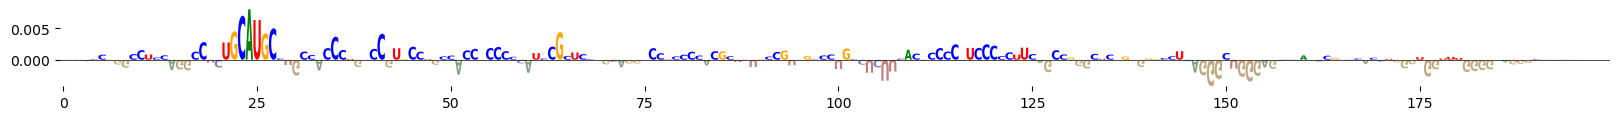

In [301]:
# # project the importance at each position onto the base that's actually present
for idx, dinuc_shuff_explanation in zip(list(range(dinuc_shuff_explanations.shape[0])), dinuc_shuff_explanations):
    
    if idx == 90:
        
        print(genes_valid.iloc[idx]['name'])
        print(genes_valid.iloc[idx]['ID'])
        print(genes_valid.iloc[idx]['0'])
        print(genes_valid.iloc[idx]['Unnamed: 0'])
        print(f"idx: {idx}")
            
        logo = logomaker.Logo(pd.DataFrame(dinuc_shuff_explanation[600:800,:], columns=['A', 'C', 'G', 'U']),
                                          shade_below=.5,
                                        fade_below=.5,
                                        # font_name='Arial Rounded MT Bold',
                                       show_spines=False,
                                        figsize=(20, 1),
                      )
        
        plt.show()

In [ ]:
break

/scratch/derek/ipykernel_387137/422997286.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set(xticklabels=['-220','-200','-180','-160','-140','-120','-100','-80','-60','-40','-20','0'])


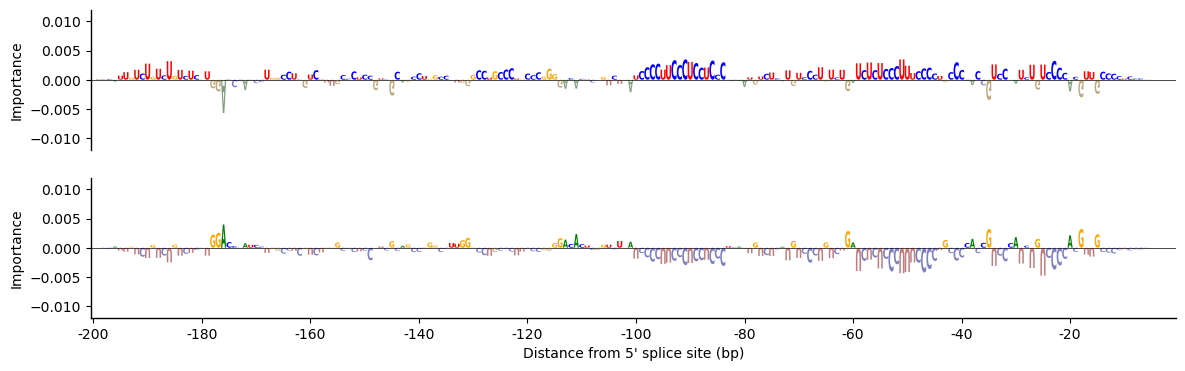

In [157]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 4))

fig.subplots_adjust(hspace=0.2)



logomaker.Logo(pd.DataFrame(dinuc_shuff_explanations_neurons[36,0:200,:], columns=['A', 'C', 'G', 'U']),
                                      shade_below=.5,
                                    fade_below=.5,
                                    # font_name='Arial Rounded MT Bold',
                                   ax = axes[0],
                                   show_spines=True
                                  )

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)

axes[0].set_ylim([-0.012, 0.012])

axes[0].get_xaxis().set_ticks([])

axes[0].set(ylabel="Importance")


logomaker.Logo(pd.DataFrame(dinuc_shuff_explanations_glia[36,0:200,:], columns=['A', 'C', 'G', 'U']),
                             
                                      shade_below=.5,
                                    fade_below=.5,
                                    # font_name='Arial Rounded MT Bold',
                                   ax = axes[1],
                                   show_spines=True
                                  )

# ax.set_xlim([xmin, xmax])
axes[1].set_ylim([-0.012, 0.012])

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

axes[1].set(xticklabels=['-220','-200','-180','-160','-140','-120','-100','-80','-60','-40','-20','0'])

axes[1].xaxis.set_major_locator(plt.MaxNLocator(11))

# axes[1].set(xticklabels=['-10','0','10','20','30','40','50','60','70','80','90','100'])


axes[1].set(xlabel="Distance from 5' splice site (bp)")

axes[1].set(ylabel="Importance")


fig.savefig('deepshap_PKM_.pdf')


# Sequentially Plot all Tracks

In [ ]:
# # project the importance at each position onto the base that's actually present
for idx, dinuc_shuff_explanation in zip(list(range(dinuc_shuff_explanations.shape[0])), dinuc_shuff_explanations):
    
    print(genes_valid.iloc[idx]['name'])
    print(genes_valid.iloc[idx]['ID'])
    print(f"idx: {idx}")
        
    logo = logomaker.Logo(pd.DataFrame(dinuc_shuff_explanation[0:seq_len,:], columns=['A', 'C', 'G', 'U']),
                                      shade_below=.5,
                                    fade_below=.5,
                                    # font_name='Arial Rounded MT Bold',
                                   show_spines=False,
                                    figsize=(60, 1),
                  )
    plt.vlines(x=(200,600), ymin= logo.ax.get_ylim()[0], ymax= logo.ax.get_ylim()[1] )
    
    plt.show()

In [ ]:
break

In [ ]:
eval_data[0].numpy()[0][]

In [ ]:
seqs_to_explain

In [ ]:
# dinuc_shuff_explanations = np.sum(raw_shap_explanations_glia, axis=-1) * seqs_to_explain


In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(20, 1.5))


logomaker.Logo(pd.DataFrame(dinuc_shuff_explanations[90,600:800,:], columns=['A', 'C', 'G', 'U']),
                                      shade_below=.5,
                                    fade_below=.5,
                                    # font_name='Arial Rounded MT Bold',
                                   ax = ax,
                                   show_spines=True
                                  )

# ax.set_xlim([xmin, xmax])
ax.set_ylim([-0.013, 0.013])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



In [ ]:
170

In [ ]:
# dinuc_shuff_explanations_neurons = dinuc_shuff_explanations.copy()

In [ ]:
pd.DataFrame(dinuc_shuff_explanations_neurons[70,0:200,:], columns=['A', 'C', 'G', 'U'])

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(22, 2))

fig.subplots_adjust(hspace=0.2)



logomaker.Logo(pd.DataFrame(dinuc_shuff_explanations_neurons[70,0:200,:], columns=['A', 'C', 'G', 'U']),
                                      shade_below=.5,
                                    fade_below=.5,
                                    # font_name='Arial Rounded MT Bold',
                                   ax = axes[0],
                                   show_spines=True
                                  )

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_visible(True)

axes[0].set_ylim([0, 0.015])

axes[0].get_xaxis().set_ticks([])

axes[0].set(ylabel="Importance")


logomaker.Logo(pd.DataFrame(dinuc_shuff_explanations[70,0:200,:], columns=['A', 'C', 'G', 'U']),
                             
                                      shade_below=.5,
                                    fade_below=1,
                                    # font_name='Arial Rounded MT Bold',
                                   ax = axes[1],
                                   show_spines=True
                                  )

# ax.set_xlim([xmin, xmax])
axes[1].set_ylim([0, 0.015])

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

axes[1].set(xticklabels=['-220','-200','-180','-160','-140','-120','-100','-80','-60'])

# axes[1].xaxis.set_major_locator(plt.MaxNLocator(10))

# axes[1].set(xticklabels=['-10','0','10','20','30','40','50','60','70','80','90','100'])


axes[1].set(xlabel="Distance from 5' splice site (bp)")

axes[1].set(ylabel="Importance")


# fig.savefig('deepshap_SCRIB_.pdf')



In [ ]:
break

# TF-MoDisco motif clustering

In [ ]:
pwd

In [ ]:
if not os.path.exists('./eval'):
    os.makedirs('./eval')
    
if not os.path.exists(f'./eval/modisco_outs'):
    os.makedirs(f'./eval/modisco_outs')
    
modisco_outs = f'./eval/modisco_outs/'

In [ ]:
# import vizsequence
import h5py as h5

# from vizsequence.viz_sequence import plot_a, plot_c, plot_g, plot_u, rna_plot_funcs

In [ ]:
np.save(modisco_outs+'ohe.npy', onehot_data.transpose(0, 2, 1))

np.save(modisco_outs+'ig.npy', dinuc_shuff_explanations.transpose(0, 2, 1))

In [ ]:
import sys
!{sys.executable} -m pip install modisco-lite

In [ ]:
%%bash

modisco motifs -h

In [ ]:
%%bash

modisco motifs -s ./eval/modisco_outs/ohe.npy \
                -a ./eval/modisco_outs/ig.npy \
                -n 2000 \
                -w 250 \
                -o modisco_results.h5 \

In [ ]:
%%bash

modisco report -i ./modisco_results.h5 \
               -o ./modisco_report/ \
               -s ./modisco_report/ \
                # -m ./motifs.ttx